# kaggleからデータをロードする

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c ai-medical-contest-2022

 99% 1.42G/1.43G [00:18<00:00, 71.2MB/s]
100% 1.43G/1.43G [00:18<00:00, 82.8MB/s]


In [6]:
! unzip ai-medical-contest-2022.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: image/image/id_01015004.png  
  inflating: image/image/id_01015005.png  
  inflating: image/image/id_01015006.png  
  inflating: image/image/id_01015007.png  
  inflating: image/image/id_01015008.png  
  inflating: image/image/id_01015009.png  
  inflating: image/image/id_01015010.png  
  inflating: image/image/id_01015011.png  
  inflating: image/image/id_01015012.png  
  inflating: image/image/id_01015013.png  
  inflating: image/image/id_01015014.png  
  inflating: image/image/id_01015015.png  
  inflating: image/image/id_01015016.png  
  inflating: image/image/id_01015017.png  
  inflating: image/image/id_01015018.png  
  inflating: image/image/id_01015019.png  
  inflating: image/image/id_01015020.png  
  inflating: image/image/id_01015021.png  
  inflating: image/image/id_01015022.png  
  inflating: image/image/id_01015023.png  
  inflating: image/image/id_01015024.png  
  inflating: image/image/id_01015025.png  
  inflating: image/ima

In [7]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pickle, time, gc, copy, sys
import pandas_profiling as pdp
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
AUTOTUNE = tf.data.experimental.AUTOTUNE

%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100) # 表示できる表の列数

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

# データ読み込み
**ファイル**

- `train.csv` - 学習用データ
- `test.csv` - テスト用データ
- `unlabeled.csv` - ラベルのない画像のデータ
- `image/` - 胸部レントゲン写真が含まれているディレクトリ。全ての画像のサイズは 256 × 256 pixel。
- `sample_submission.csv` - 提出ファイルのサンプル。0 から 1 の間の値の予測結果を`pneumonia`列に代入して提出してください。

**データ内容**

- `id` - 匿名化された画像ID. 全ての画像データはそれぞれ異なる患者から撮影されています.
- `pneumonia` - 目的変数. 0=正常, 1=肺炎 (test.csv にはありません)
- `source` - 胸部レントゲン写真を取得したデータセット(AまたはB)を表しています。

In [9]:
# ファイルを読み込む
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df_unlabeled = pd.read_csv("./unlabeled.csv")
df_sub = pd.read_csv("./sample_submission.csv")

# 画像データのpathの列を追加.
df_train['path'] = df_train['id'].apply(lambda x: "./image/image/{}.png".format(x))
df_test['path'] = df_test['id'].apply(lambda x: "./image/image/{}.png".format(x))
df_unlabeled['path'] = df_unlabeled['id'].apply(lambda x: "./image/image/{}.png".format(x))
print(df_train['path'][0]) # path列の0行目を表示
df_train.head()

./image/image/id_00000000.png


,id,pneumonia,source,path
0,id_00000000,0,A,./image/image/id_00000000.png
1,id_00000001,1,A,./image/image/id_00000001.png
2,id_00000002,0,A,./image/image/id_00000002.png
3,id_00000003,1,A,./image/image/id_00000003.png
4,id_00000004,0,A,./image/image/id_00000004.png


# EDA (Explanatory Data Analysis, 探索的データ解析)

In [10]:
# 目的変数について解析
col_target = 'pneumonia' # 目的変数の列
col_index = 'id' # idの列
print("rate of positive: {:.6f}".format(df_train[col_target].mean())) # 目的変数が1である割合

rate of positive: 0.500000


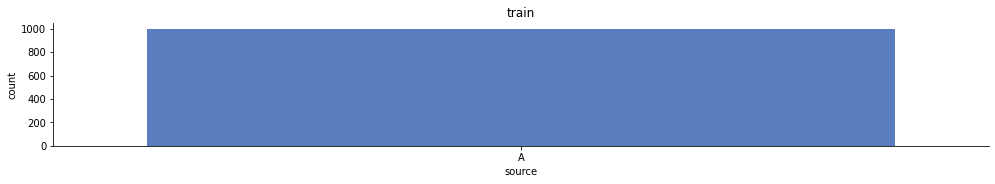

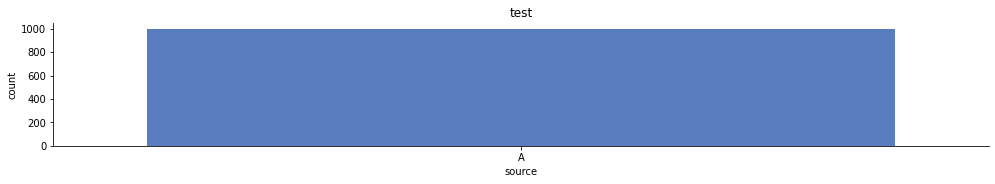

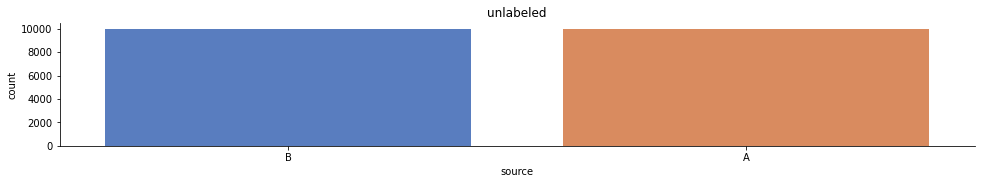

In [11]:
# カテゴリ変数について棒グラフを表示する
# 解析対象はtrain+test

def barplot(df, col, title):
    '''
    棒グラフを表示する関数を定義する。
    引数:
        df: 棒グラフを表示するデータフレーム
        col: 棒グラフを表示する列名
        title: グラフのタイトル
    '''
    g = sns.catplot(
            x=col,  
            kind="count",
            data=df, # 解析するDataFrame
            height=5, 
            palette="muted"
        )
    g.fig.set_figwidth(16)
    g.fig.set_figheight(2)
    plt.title(title)
    plt.show()

col = 'source' # 解析する列名
barplot(df_train, col, 'train')
barplot(df_test, col, 'test')
barplot(df_unlabeled, col, 'unlabeled')

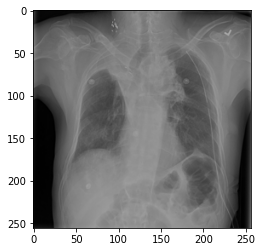

In [12]:
img = cv2.imread('./image/image/id_00000000.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

sourceはtrain, testは全てデータセットA由来、unlabeledは半分がA由来、残り半分がB由来である.

len(df_train): 1000
i: 72
path: ./image/image/id_00000072.png
img_i.shape: (256, 256, 3)


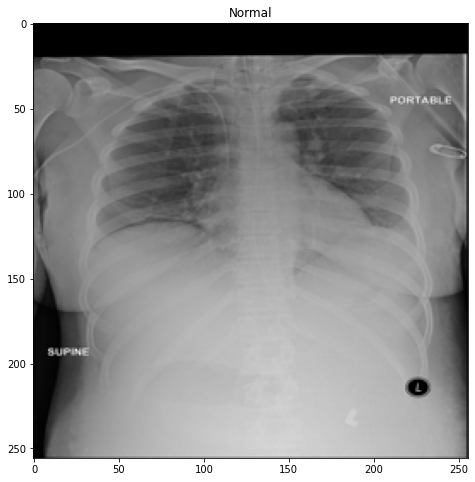

In [76]:
# 画像を表示する
print('len(df_train):', len(df_train)) # trainの行数を表示
i = np.random.randint(len(df_train)) # 0～trainの行数までの整数を一つランダムに選ぶ
print('i:', i)
print('path:', df_train['path'][i]) # i行目のpathを表示する
img_i = cv2.imread(df_train['path'][i]) # i行目の画像を読み込む
img_i = img_i[:,:,::-1] # 色情報をBGRからRGBに並び替える
print('img_i.shape:', img_i.shape) # 画像のサイズを表示する
target = 'Normal' if df_train['pneumonia'][i]==0 else 'Pneumonia' # i行目のデータがNormalかPneumoniaか
plt.figure(figsize=(8,8)) # 画像の表示の大きさを指定
plt.imshow(img_i) # 画像を表示する
plt.title(target) # 画像が正常か肺炎かを表示
plt.show()

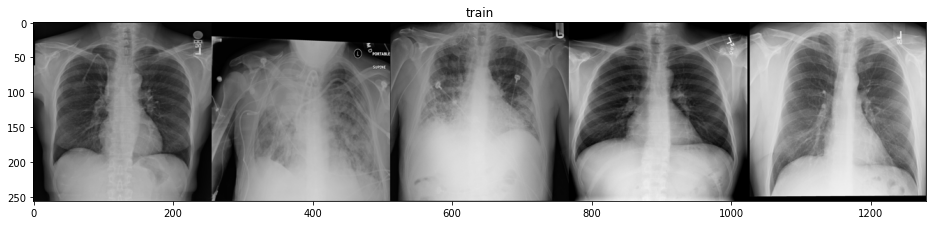

In [14]:
# 画像を複数表示する
def show_images(paths, num_show=5, title='', seed=None, debug=None):
    '''
    引数として与えられた画像のpathのリストからランダムに複数枚画像を読み込んで表示する関数を作成する。
    引数:
        paths: 画像のpathのリスト
        num_show: 表示する画像の枚数
        title: 表示するグラフのタイトル
        seed: 乱数のシード. 数値を指定した場合常に同じ画像が表示される.
    '''
    if seed is not None:
        np.random.seed(seed)
    index_tmp = np.random.randint(0, len(paths), num_show) # 読み込む画像の行番号をランダム選択する
    if debug: print(index_tmp)
    imgs = [cv2.imread(paths[i]) for i in index_tmp] # 画像を読み込みリストにする。
    imgs = np.concatenate(imgs, axis=1) # 画像を横に連結する。
    plt.figure(figsize=(16,16))
    plt.title(title) # グラフのタイトル
    plt.imshow(imgs)
    plt.show()

show_images(
    paths=df_train['path'], # 画像のpathのリスト
    num_show=5, # 表示する画像の枚数
    title='train', #表示するグラフのタイトル
)

len(df_positive): 500
len(df_negative): 500
len(df_A): 10000
len(df_B): 10000


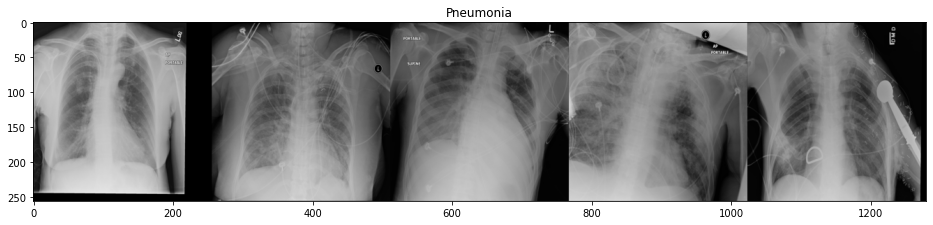

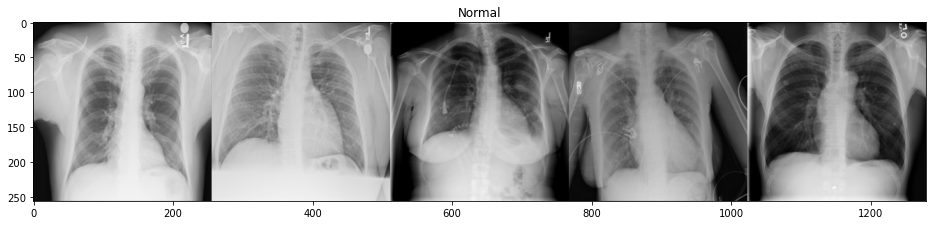

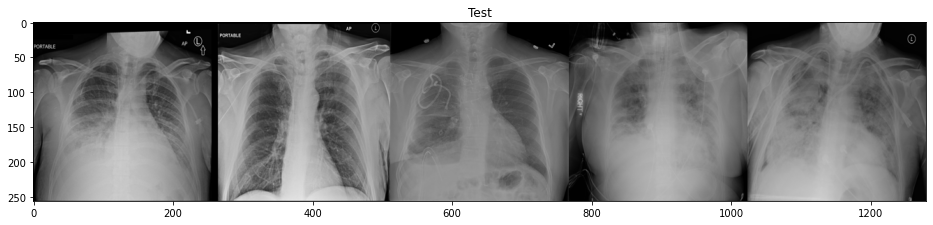

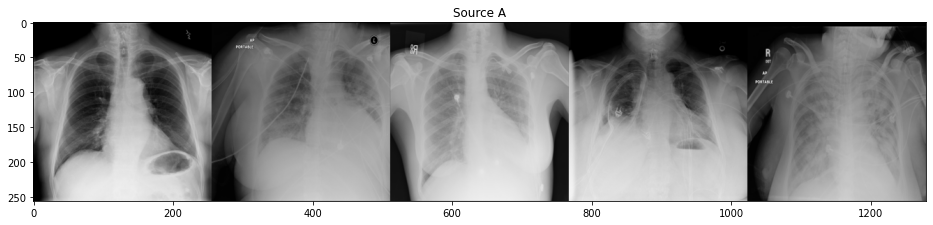

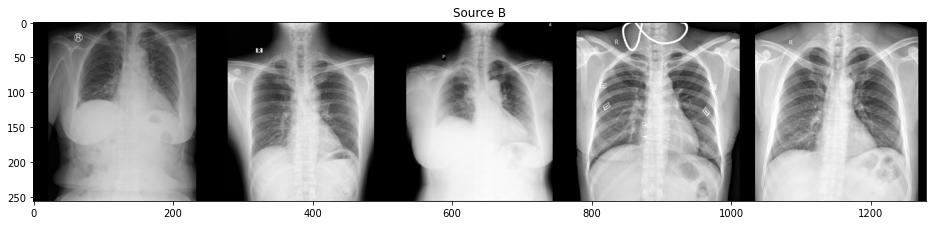

In [15]:
# 各データの画像を表示
df_positive = df_train[df_train['pneumonia']==1].reset_index(drop=True) # trainから肺炎の行だけを抽出.
df_negative = df_train[df_train['pneumonia']==0].reset_index(drop=True) # trainから正常の行だけを抽出.
df_A = df_unlabeled[df_unlabeled['source']=='A'].reset_index(drop=True) # unlabeledデータからソースがAの行だけを抽出
df_B = df_unlabeled[df_unlabeled['source']=='B'].reset_index(drop=True) # unlabeledデータからソースがBの行だけを抽出

print('len(df_positive):', len(df_positive))
print('len(df_negative):', len(df_negative))
print('len(df_A):', len(df_A))
print('len(df_B):', len(df_B))

show_images(df_positive['path'], 5, 'Pneumonia') # trainの肺炎画像を5枚表示
show_images(df_negative['path'], 5, 'Normal') # trainの正常画像を5枚表示
show_images(df_test['path'], 5, 'Test') # testの画像を5枚表示
show_images(df_A['path'], 5, 'Source A') # ソースAのラベルなし画像を5枚表示
show_images(df_B['path'], 5, 'Source B') # ソースBのラベルなし画像を5枚表示

# クロスバリデーションの設定

In [25]:
# クロスバリデーションを行うためにデータを5分割する
# 4つを学習に用い、1つを検証に要する。これを5回繰り返す。
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(
    np.arange(len(df_train)), 
    y=df_train[col_target]) # 各foldターゲットのラベルの分布がそろうようにする = stratified K fold
)

In [26]:
# fold 0 の学習データと検証データの分割
fold = 0 # fold 0 についての学習を行う

# このfoldにおける学習データと検証データの切り分け
# folds[x][0]=x番目のfoldの学習用の行番号リスト
# folds[x][1]=x番目のfoldの検証用の行番号リスト
df_train_fold = df_train.iloc[folds[fold][0]].reset_index(drop=True) # 学習データの入力データを抽出. 
df_valid = df_train.iloc[folds[fold][1]].reset_index(drop=True) # 検証データの入力データを抽出
print("df_train_fold.shape: {}".format(df_train_fold.shape))
print("df_valid.shape: {}".format(df_valid.shape))

df_train_fold.shape: (800, 4)
df_valid.shape: (200, 4)


# いろいろな画像の処理を変更する

Found 800 validated image filenames.
X.shape: (64, 256, 256, 3)
y.shape: (64,)
X[0]:  [[[0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]]

 [[0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]]

 [[0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]]

 ...

 [[0.5058824  0.5058824  0.5058824 ]
  [0.5058824  0.5058824  0.5058824 ]
  [0.5058824  0.5058824  0.5058824 ]
  ...
  [0.36862746 0.36862746 0.36862746]
  [0.36862746 0.36862746 0.36862746]
  [0.36862746 0.36862746 0.

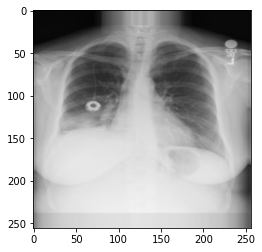

In [140]:
# 学習用のデータ読み込みパイプラインを作成する
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( # 画像読み込み時の設定を行う
        rescale=1./255,                             #  画像の値は0~255なので255で割り0~1で正規化する
        zoom_range=0.2,                           # 画像を±0.2の範囲で拡大縮小する.
#        rotation_range=5,                        # 画像を±20°の範囲で回転する.
#        width_shift_range=0.1,                    # 画像を±0.2の範囲で左右に平行移動.
#        height_shift_range=0.2,                   # 画像を±0.2の範囲で上下に平行移動.
#        brightness_range=[0.3, 1.0],              # [0.3, 1.0] の範囲でランダムに明度を変更する.
#        featurewise_center=True,                  # データセット全体で各チャンネルごとの画素値の平均を0にする.
#        featurewise_std_normalization=True,       # データセット全体で各チャンネルごとの画素値の分散を1にする.(featurewise_center=Trueとセットで使う)
#        samplewise_center=True,                    # サンプルごとの画素値の平均を0にする.
#        samplewise_std_normalization=True,        # サンプルごとの画素値の分散を1にする.(samplewise_center=Trueとセットで使う)
        horizontal_flip=True,                         # 画像を50%の確率で左右反転する.
)

train_generator = train_datagen.flow_from_dataframe( # 読み込むデータの指定
    dataframe=df_train_fold, # 読み込むデータフレーム 
    x_col='path', # 画像pathの列名
    y_col='pneumonia', # 目的変数の列名
    batch_size=64, # バッチサイズ=1回の学習ごとの入力画像枚数
    class_mode='raw' # 目的変数の型. 数値であれば'raw'
)
X, y = next(train_generator) # データ読み込みパイプラインから試しにデータを読み込んでみる
print("X.shape:", X.shape) # 入力データのミニバッチ
print("y.shape:", y.shape) # 出力データのミニバッチ
print('X[0]: ', X[0])
print('y: ', y)
plt.imshow(X[0])
plt.show()

In [141]:
# 検証用のデータ読み込みパイプラインを作成する

valid_datagen = ImageDataGenerator(
        rescale=1./255,
# 検証データに対してはデータ水増しを行わないのでデータ水増しの設定はコメントアウトする.
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='path',
    y_col='pneumonia',
    batch_size=32,
    class_mode='raw',
    shuffle=False, # データのシャッフルを行わない
)

Found 200 validated image filenames.


# EfficientNetの構築

In [18]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 6.3 MB/s 


In [59]:
import efficientnet.tfkeras

In [142]:
input_shape = (256, 256, 3)
model = tf.keras.Sequential([
        efficientnet.tfkeras.EfficientNetB1(input_shape=input_shape,
                                            weights=None,  #事前学習の設定
                                            include_top=False),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=["accuracy", 'AUC']
)

In [130]:
# 学習の実行
# モデルの保存方法の指定
checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, # 保存path
    save_weights_only=True, # 重みのみを保存
    monitor='val_auc', # validataionのAUCの値に基づいて重みを保存する
    mode='max', # validataionのAUCが最大となった時重みを保存する
    save_best_only=True # AUCが改善したときのみ保存する
)

history = model.fit(
    train_generator,  # 学習に用いるdataset
    validation_data=valid_generator, # 検証に用いるdataset
    epochs=50, # 学習のepoch数. 1epoch=全データを1回ずつモデルに入力するまで
    callbacks=[model_checkpoint_callback], # モデル保存方法の指定
         )

Epoch 1/50
13/13 [==============================] - 16s 1s/step - loss: 0.8234 - accuracy: 0.5275 - auc: 0.5371 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/50
13/13 [==============================] - 12s 900ms/step - loss: 0.7803 - accuracy: 0.5900 - auc: 0.6075 - val_loss: 0.6954 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/50
13/13 [==============================] - 12s 893ms/step - loss: 0.7474 - accuracy: 0.6212 - auc: 0.6577 - val_loss: 0.7235 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/50
13/13 [==============================] - 12s 900ms/step - loss: 0.6868 - accuracy: 0.6388 - auc: 0.6695 - val_loss: 0.7109 - val_accuracy: 0.5000 - val_auc: 0.4950
Epoch 5/50
13/13 [==============================] - 12s 885ms/step - loss: 0.6574 - accuracy: 0.6600 - auc: 0.6944 - val_loss: 0.7463 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 6/50
13/13 [==============================] - 12s 902ms/step - loss: 0.6532 - accuracy: 0.6875 - auc: 0.7041 - val_loss: 0

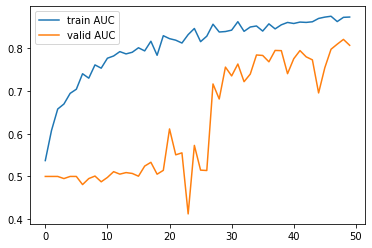

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.823350,0.52750,0.537097,0.693284,0.500,0.50000
1,0.780349,0.59000,0.607550,0.695368,0.500,0.50000
2,0.747425,0.62125,0.657744,0.723484,0.500,0.50000
3,0.686772,0.63875,0.669475,0.710921,0.500,0.49500
4,0.657446,0.66000,0.694372,0.746273,0.500,0.50000
5,0.653208,0.68750,0.704084,0.786970,0.500,0.50000
6,0.612225,0.69875,0.740287,0.803856,0.500,0.48095
7,0.614382,0.68500,0.729963,0.728454,0.500,0.49500
8,0.597579,0.69500,0.760994,0.739232,0.500,0.50090
9,0.599184,0.71625,0.753328,0.770185,0.500,0.48745


In [131]:
train_log = pd.DataFrame(history.history) # 学習ログをデータフレーム形式に変換
train_log.to_csv("train_log.csv", index=None) # 学習ログを保存

#学習ログをグラフ表示する
plt.plot(np.arange(len(train_log)), train_log['auc'], label='train AUC')
plt.plot(np.arange(len(train_log)), train_log['val_auc'], label='valid AUC')
plt.legend()
plt.show()

train_log # 学習ログを表示

# 学習したモデルを評価する

In [132]:
# 検証データに対する予測結果を出力する
# 予測
checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
model.load_weights(checkpoint_filepath) # 最もvalid AUCが高かったエポックの重みを読み込む
pred_valid = model.predict(valid_generator) # 予測の実行
print(pred_valid.shape)
df_valid = df_train.iloc[folds[fold][1]].reset_index(drop=True)
valid_auc = metrics.roc_auc_score(df_valid[col_target], pred_valid)
print("CV: {:.6f}".format(valid_auc))

(200, 1)
CV: 0.820600


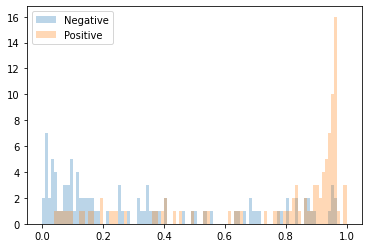

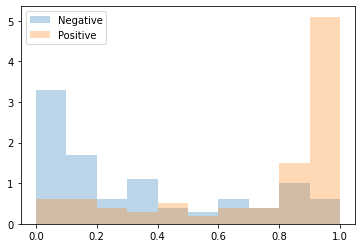

In [133]:
# 予測結果をヒストグラムで表示
# ヒストグラムの山がしっかり分離していれば良く予想できているといえる
plt.hist(pred_valid[df_valid['pneumonia']==0], alpha=0.3, label='Negative',
         bins=np.arange(101)/100, 
         density=True)
plt.hist(pred_valid[df_valid['pneumonia']==1], alpha=0.3, label='Positive',
         bins=np.arange(101)/100, 
         density=True
        )

plt.legend()
plt.show()

plt.hist(pred_valid[df_valid['pneumonia']==0], alpha=0.3, label='Negative',
         bins=np.arange(11)/10, 
         density=True)
plt.hist(pred_valid[df_valid['pneumonia']==1], alpha=0.3, label='Positive',
         bins=np.arange(11)/10, 
         density=True
        )

plt.legend()
plt.show()

Found 20000 validated image filenames.


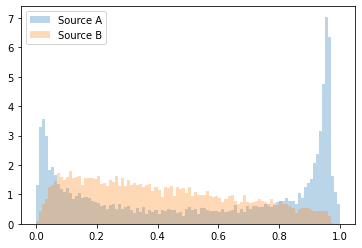

CPU times: user 1min 33s, sys: 1.62 s, total: 1min 34s
Wall time: 55.2 s


In [134]:
%%time
# ラベルなしデータに対する予測結果を出力する (90秒かかる)
df_unlabeled['pneumonia'] = 0.5

unlabeled_datagen = ImageDataGenerator(
        rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    dataframe=df_unlabeled,
    x_col='path',
    y_col='pneumonia',
    batch_size=32,
    class_mode='raw',
    shuffle=False,
)

# 予測
checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
model.load_weights(checkpoint_filepath) # 最もvalid AUCが高かったエポックの重みを読み込む
pred_unlabeled = model.predict(unlabeled_generator) # 予測の実行

plt.hist(pred_unlabeled[df_unlabeled['source']=='A'], alpha=0.3, label='Source A',
         bins=np.arange(101)/100, 
         density=True)
plt.hist(pred_unlabeled[df_unlabeled['source']=='B'], alpha=0.3, label='Source B',
         bins=np.arange(101)/100, 
         density=True
        )

plt.legend()
plt.show()

# 半教師あり学習(Pseudo labeling)
- 教師あり学習 - 全てのデータにラベル情報があるデータを用いた学習
- 半教師あり学習 - ラベルがあるデータとラベルがないデータの2種類を用いた学習. 十分な数のラベル情報がない際に有用.
- Pseudo labeling (疑似ラベリング) - 半教師あり学習のひとつ. 通常の教師あり学習でモデルを学習させた後にそのモデルを使ってラベルのないデータに対してラベルを予想し、その結果を疑似ラベルとして新たに学習用のデータとする手法.

**Step1**  
![step1](https://miro.medium.com/max/986/1*YfvVYAbq18ziut08r8znhQ.jpeg)  

---
**Step2**  
![step2](https://miro.medium.com/max/974/1*m7xbddgfRP7CepNd1GTe2A.jpeg)  

---
**Step3**  
![step3](https://miro.medium.com/max/974/1*3xJd7IbvOT-oiJ0rJ1mmUQ.jpeg)  

In [135]:
# Pseudo labelの作成
df_unlabeled['pred'] = pred_unlabeled # ラベルなしデータに対するラベルの予測結果をpred列として代入
df_A = df_unlabeled[df_unlabeled['source']=='A'].reset_index(drop=True) # ソースAのデータのみ抽出
df_negative = df_A[df_A['pred']<0.1] # 予測結果が0.1以下のデータを抽出し、
df_negative['pneumonia'] = 0 # ラベル=0のデータとして扱う
df_positive = df_A[df_A['pred']>0.9] # 予測結果が0.9以上のデータを抽出し、
df_positive['pneumonia'] = 1 # ラベル=1のデータとして扱う

print('df_negative.shape', df_negative.shape)
print('df_positive.shape', df_positive.shape)

# df_positiveとdf_negativeとして疑似ラベルのデータフレームとする
df_pseudo = pd.concat([df_negative, df_positive]).reset_index(drop=True)
df_pseudo.head()

df_negative.shape (2023, 5)
df_positive.shape (3064, 5)


,id,source,path,pneumonia,pred
0,id_01000003,A,./image/image/id_01000003.png,0,0.011172
1,id_01000006,A,./image/image/id_01000006.png,0,0.011227
2,id_01000047,A,./image/image/id_01000047.png,0,0.014419
3,id_01000087,A,./image/image/id_01000087.png,0,0.032161
4,id_01000091,A,./image/image/id_01000091.png,0,0.035846


In [136]:
# ミニバッチ生成を行う際にデータの抽出する比率 (weight)を設定する
df_train['weight'] = 1 # データをミニバッチに抽出するときの重み付け. 本来のtrainデータの重みは大きく設定
df_pseudo['weight'] = 0.2 # pseudo labelは本来のtrainデータに比べて信頼性が低いので重みは小さく設定

In [137]:
# Pseudo labelのデータを含むデータ読み込みパイプラインを作成する
# 本来のtrainデータとpseudo labelデータを連結
df_train_pl = pd.concat([df_train.iloc[folds[fold][0]] ,df_pseudo]).reset_index(drop=True)

train_datagen2 = ImageDataGenerator(
        rescale=1./255,
#         shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator2 = train_datagen2.flow_from_dataframe(
    dataframe=df_train_pl,
    x_col='path',
    y_col='pneumonia',
    sample_weight=df_train_pl['weight'], # データ抽出比率の情報を指定
    batch_size=32,
    class_mode='raw',
)

Found 5887 validated image filenames.


In [138]:
# Pseudo labelを用いた学習の実行
#inputs = keras.Input(shape=(None, None, 3))
#outputs = resnet18(inputs)
#model = keras.Model(inputs, outputs)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#             loss='binary_crossentropy',
#             metrics=["accuracy", 'AUC'])

# モデルの保存方法の指定
checkpoint_filepath = "weight_pl_fold{}.ckpt".format(fold)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, # 保存path
    save_weights_only=True, # 重みのみを保存
    monitor='val_auc', # validataionのAUCの値に基づいて重みを保存する
    mode='max', # validataionのAUCが最大となった時重みを保存する
    save_best_only=True # AUCが改善したときのみ保存する
)

history2 = model.fit(train_generator2, epochs=16, 
          
    validation_data=valid_generator, # 検証に用いるdataset
    callbacks=[model_checkpoint_callback], # モデル保存方法の指定
    steps_per_epoch=50, # 1epoch内の学習ステップの数を指定
         )

Epoch 1/16
50/50 [==============================] - 23s 460ms/step - loss: 0.1701 - accuracy: 0.9406 - auc: 0.9785 - val_loss: 1.8335 - val_accuracy: 0.6950 - val_auc: 0.7439
Epoch 2/16
50/50 [==============================] - 24s 474ms/step - loss: 0.1253 - accuracy: 0.9638 - auc: 0.9870 - val_loss: 0.9242 - val_accuracy: 0.7300 - val_auc: 0.8013
Epoch 3/16
50/50 [==============================] - 24s 463ms/step - loss: 0.1552 - accuracy: 0.9556 - auc: 0.9789 - val_loss: 5.3550 - val_accuracy: 0.7450 - val_auc: 0.7726
Epoch 4/16
50/50 [==============================] - 23s 462ms/step - loss: 0.1465 - accuracy: 0.9556 - auc: 0.9830 - val_loss: 2.0552 - val_accuracy: 0.7450 - val_auc: 0.7745
Epoch 5/16
50/50 [==============================] - 23s 456ms/step - loss: 0.1450 - accuracy: 0.9469 - auc: 0.9848 - val_loss: 1.0348 - val_accuracy: 0.6750 - val_auc: 0.7791
Epoch 6/16
50/50 [==============================] - 23s 459ms/step - loss: 0.1210 - accuracy: 0.9619 - auc: 0.9883 - val_loss

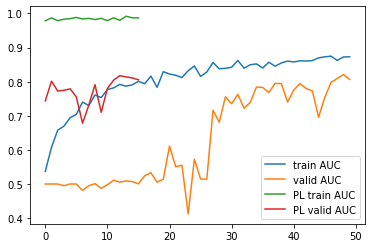

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.170099,0.940625,0.978507,1.833526,0.695,0.74385
1,0.125319,0.963750,0.986958,0.924246,0.730,0.80130
2,0.155247,0.955597,0.978874,5.354987,0.745,0.77260
3,0.146454,0.955625,0.983013,2.055188,0.745,0.77455
4,0.144990,0.946875,0.984833,1.034785,0.675,0.77910
5,0.121005,0.961875,0.988273,3.253632,0.675,0.75480
6,0.135727,0.958099,0.983782,6.575871,0.530,0.67815
7,0.138223,0.954375,0.985505,3.662974,0.665,0.73090
8,0.145909,0.959975,0.982163,1.076290,0.725,0.79115
9,0.123574,0.963727,0.985570,2.423002,0.630,0.71010


In [139]:
train_log2 = pd.DataFrame(history2.history) # 学習ログをデータフレーム形式に変換
train_log2.to_csv("train_log2.csv", index=None) # 学習ログを保存

#学習ログをグラフ表示する
plt.plot(np.arange(len(train_log)), train_log['auc'], label='train AUC')
plt.plot(np.arange(len(train_log)), train_log['val_auc'], label='valid AUC')
plt.plot(np.arange(len(train_log2)), train_log2['auc'], label='PL train AUC')
plt.plot(np.arange(len(train_log2)), train_log2['val_auc'], label='PL valid AUC')
plt.legend()
plt.show()

train_log2 # 学習ログを表示

# 提出ファイルの作成

Found 1000 validated image filenames.
pred_test.shape: (1000, 1)


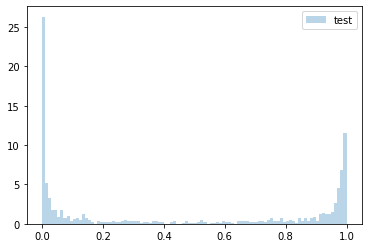

In [96]:
# test dataに対する予測
df_test['pneumonia'] = 0.5
fold = 0

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='pneumonia',
    batch_size=32,
    class_mode='raw',
    shuffle=False,
)

# 予測
checkpoint_filepath = "weight_pl_fold{}.ckpt".format(fold)
model.load_weights(checkpoint_filepath) # 最もvalid AUCが高かったエポックの重みを読み込む
pred_test = model.predict(test_generator) # 予測の実行
print("pred_test.shape: {}".format(pred_test.shape))
plt.hist(pred_test, alpha=0.3, label='test',
         bins=np.arange(101)/100, 
         density=True)
plt.legend()
plt.show()

In [97]:
### submitファイルを作成
df_sub['pneumonia'] = pred_test # 推定結果を代入
df_sub.to_csv("submission.csv", index=None) # submitファイルを保存
df_sub.head() # 最初の5行を表示

,id,pneumonia
0,id_00010000,0.104084
1,id_00010001,0.882209
2,id_00010002,0.933985
3,id_00010003,0.007385
4,id_00010004,0.000738


In [98]:
from google.colab import files
files.download("submission.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 次にすること
- Cross validationの全foldの学習を行い各foldの予測結果を平均する
- modelの構造を変更する (`resnet(inputs, [2, 2, 2, 2])`のところの数値を変えることでレイヤー数を変更できる)
- augmentation を加える (`ImageDataGenerator`のコメントアウトを外したり、数値を変更する)
- ハイパーパラメータ･チューニング (epoch を増やす, learning rate を減らす, etc)
- より精度の高いモデルでPseudo labelingを行う
- ソースBの画像も活用する
- その他の半教師あり学習手法

# 注意
外部データは事前学習済みモデルも含めて使用禁止です。
ライブラリを使用していると気づかず事前学習済みモデルを読み込んでいることがあるので注意してください。
kaggle notebook上でコードを書く場合はinternetをオフにしておけば事前学習済みモデルが読み込めないので確実です。  
kaggle notebookはGPUの使用時間に上限があるので注意してください (右側に表示されています).